# Deep Learning and Applied AI (DLAI) Project: **Fine-Tuning a Large Language Model (LLM) for Italian-to-Neapolitan Dialect Translation**

# Part I: Data Analysis

### Author: Aur Marina Iuliana, 1809715

# 1. Import Libraries

In [2]:
import numpy as np
import pandas as pd
import os

import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns
import json
import glob

from datasets import Dataset, load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from sklearn.model_selection import train_test_split

from datasets import load_dataset
import re
import json

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from collections import Counter
from wordcloud import WordCloud

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 2. Import Data

In [3]:
# Import raw data
nap_dataset = load_dataset("efederici/mt_nap_it", split = "train")
nap_dataset

Dataset({
    features: ['url', 'napoletano', 'italiano'],
    num_rows: 14150
})

In [4]:
nap_data_df = pd.DataFrame(nap_dataset)
nap_data_df.head()

,url,napoletano,italiano
0,https://www.napoligrafia.it/musica/testi/videN...,Ma 'int'ô tramonto 'nterra Pusilleco,Ma al tramonto giù a Posillipo
1,https://www.napoligrafia.it/musica/testi/maist...,so' scese stasera,sono scese stasera
2,https://www.napoligrafia.it/musica/testi/oMare...,"bbraccelle, ajutame a tirà, ca 'stu marenariello","aiutami a tirare, che questo marinaretto. ti v..."
3,https://www.napoligrafia.it/musica/testi/nuQua...,e no pecché t'aggio perduto,e non perchè ti ho perso
4,https://www.napoligrafia.it/musica/testi/carav...,Cu 'o fiasco 'mmano e cu 'o,Con il fiasco in mano e col


In [5]:
print("-----------------Example of one sample in the dataset: -----------------\n")
print(f"Neapolitan Text: {nap_data_df['napoletano'][0]}")
print(f"Italian Text: {nap_data_df['italiano'][0]}")

-----------------Example of one sample in the dataset: -----------------

Neapolitan Text: Ma 'int'ô tramonto 'nterra Pusilleco
Italian Text: Ma al tramonto giù a Posillipo


# 3. Exploratory Data Analysis (EDA)

## 3.1 Words Distribution

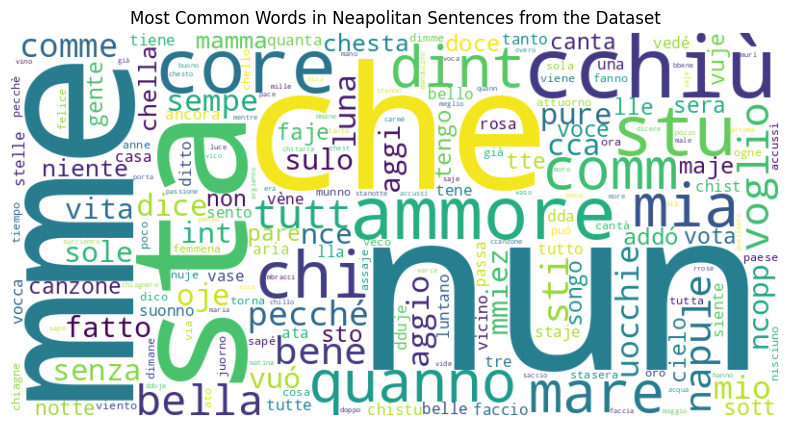

In [6]:
# Initialize a Counter
word_counts = Counter()

# Compute word frequencies
for text in nap_data_df['napoletano']:
  words = [word for word in re.findall(r'\b\w+\b', text.lower()) if len(word) >= 3]
  word_counts.update(words)

# Generate the word cloud using the word frequencies
wordcloud = WordCloud(width = 800, height = 400, background_color = "white").generate_from_frequencies(word_counts)

plt.figure(figsize = (10, 5))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.title("Most Common Words in Neapolitan Sentences from the Dataset")
plt.axis("off")
plt.show()

In [7]:
# Compute the percentage distribution of the 10 most common words
total_words = sum(word_counts.values())
word_percentage = {word: (count / total_words) * 100 for word, count in word_counts.items()}

print("Percentage Distribution of the 10 Most Common Words in Neapolitan Sentences from the Dataset: \n")
for word, percentage in sorted(word_percentage.items(), key = lambda item: item[1], reverse = True)[:10]:
    print(f"{word}: {percentage:.2f}%")

Percentage Distribution of the 10 Most Common Words in Neapolitan Sentences from the Dataset: 

nun: 2.86%
mme: 2.14%
che: 1.54%
sta: 1.37%
cchiù: 1.26%
core: 1.01%
ammore: 0.95%
stu: 0.83%
chi: 0.72%
mia: 0.61%


## 3.2 Lexical Diversity

In [8]:
# Compute Lexical Diversity as the ratio of unique tokens to total tokens
tokens = [word for text in nap_data_df['napoletano'] for word in text.split()]

total_tokens = len(tokens)
unique_tokens = len(set(tokens)) 
information_density = (unique_tokens / total_tokens)

print(f"Total Tokens: {total_tokens}")
print(f"Unique Tokens: {unique_tokens}")
print(f"Lexical Diversity: {information_density:.2f}")

Total Tokens: 104962
Unique Tokens: 17279
Lexical Diversity: 0.16


## 3.3 Sentence Length Distribution

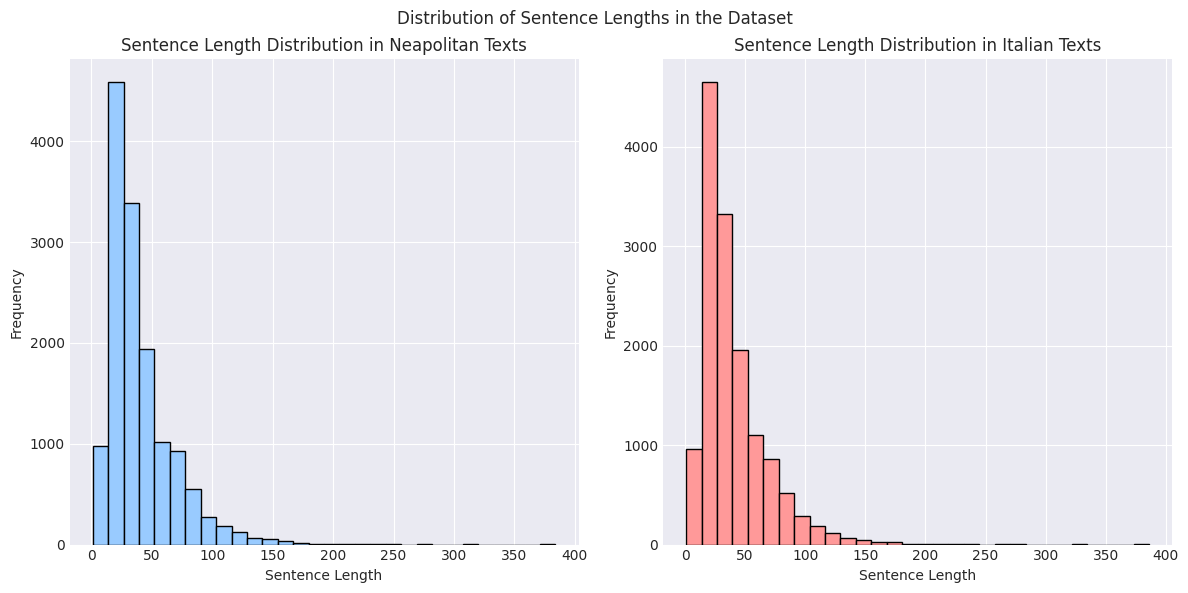

In [11]:
# Compute sentence lengths for Neapolitan and Italian texts
nap_lens = nap_data_df['napoletano'].apply(len)
ita_lens = nap_data_df['italiano'].apply(len)

# Plot histogram for Neapolitan sentence lengths
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.hist(nap_lens, bins = 30, color = "#99CBFF", edgecolor = "black")
plt.title("Sentence Length Distribution in Neapolitan Texts")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.style.use("seaborn-v0_8-darkgrid")

# Plot histogram for Italian sentence lengths
plt.subplot(1, 2, 2)
plt.hist(ita_lens, bins = 30, color = "#FF9999", edgecolor = "black")
plt.title("Sentence Length Distribution in Italian Texts")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.style.use("seaborn-v0_8-darkgrid")

# Display the plots
plt.tight_layout(rect = [0, 0, 1, 0.96])
plt.suptitle("Distribution of Sentence Lengths in the Dataset")
plt.show()

In [12]:
# Compute the average length of sentences in the Neapolitan texts
nap_mean = nap_lens.mean()
print(f"Mean Sentence Length in Neapolitan Texts: {nap_mean:.2f}")

# Compute the average length of sentences in the Italian texts
ita_mean = ita_lens.mean()
print(f"Mean Sentence Length in Italian Texts: {ita_mean:.2f}")


Mean Sentence Length in Neapolitan Texts: 40.21
Mean Sentence Length in Italian Texts: 40.12


## 3.4 Linguistic Divergence 

In [13]:
# Load a pre-trained model and tokenizer 
model_id = "google/gemma-2-2b-it"

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map = "auto",
    trust_remote_code = True,
)

tokenizer = AutoTokenizer.from_pretrained(model_id)

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


In [14]:
def get_embedding(text, model, tokenizer):
  '''
  Function to get the embedding of a given text using a pre-trained model.
  '''
  tokenized_text = tokenizer(text, return_tensors="pt", truncation = True, max_length = 256)
  tokenized_text = {key: value.to(model.device) for key, value in tokenized_text.items()}  
  with torch.no_grad():
    outputs = model(**tokenized_text, output_hidden_states = True)

  hidden_states = outputs.hidden_states[-1]
  sentence_embedding = hidden_states.mean(dim = 1)
  return sentence_embedding

In [15]:
# Compute the linguistic divergence between Neapolitan and Italian text embeddings
divergence_scores = []
nap_embeddings = []
ita_embeddings = []

for nap_text, ita_text in zip(nap_data_df['napoletano'][:5000], nap_data_df['italiano'][:5000]):

  # Get Neapolitan text embeddings
  nap_embedding = get_embedding(nap_text, model, tokenizer)
  nap_embedding_np = nap_embedding.cpu().numpy()
  nap_embeddings.append(nap_embedding_np.flatten())

  # Get Italian text embeddings
  ita_embedding = get_embedding(ita_text, model, tokenizer)
  ita_embedding_np = ita_embedding.cpu().numpy()
  ita_embeddings.append(ita_embedding_np.flatten())

  # Calculate cosine similarity and divergence scores
  divergence = 1 - cosine_similarity(nap_embedding_np, ita_embedding_np)
  divergence_scores.append(divergence[0])

In [18]:
print(f'Average Linguistic Divergence of Neapolitan Dialect from Italian Language: {np.mean(divergence_scores):.3f}')

Average Linguistic Divergence of Neapolitan Dialect from Italian Language: 0.155


## 3.5 Embeddings Representation 

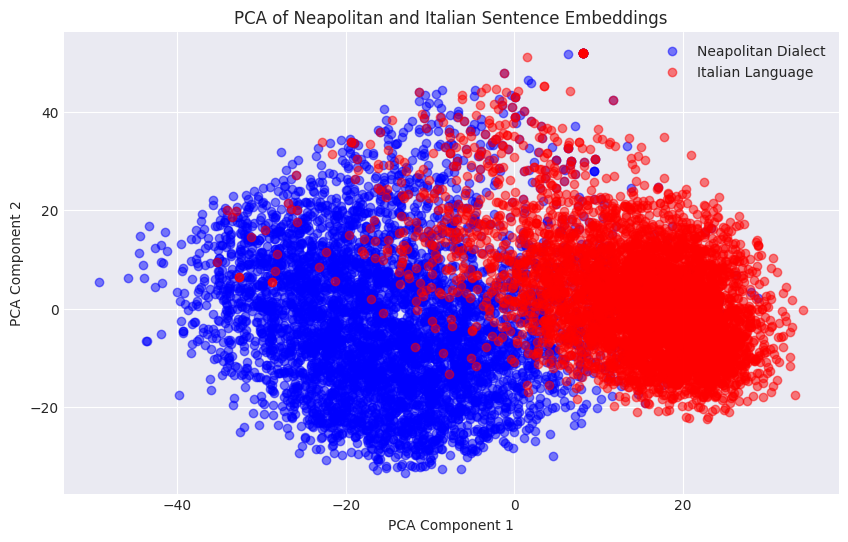

In [19]:
all_embeddings = np.concatenate((nap_embeddings, ita_embeddings), axis=0)
scaler = StandardScaler()
all_embeddings_scaled = scaler.fit_transform(all_embeddings)

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(all_embeddings_scaled)

plt.figure(figsize = (10, 6))
plt.scatter(embeddings_2d[:len(nap_embeddings), 0], embeddings_2d[:len(nap_embeddings), 1], label = 'Neapolitan Dialect', color = 'blue', alpha = 0.5)
plt.scatter(embeddings_2d[len(nap_embeddings):, 0], embeddings_2d[len(nap_embeddings):, 1], label = 'Italian Language', color = 'red', alpha = 0.5)

plt.title('PCA of Neapolitan and Italian Sentence Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()

plt.show()